<a href="https://colab.research.google.com/github/fernerman/ML_Project/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Kaggle NLP competition**

###Importing libraries

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Reading Dataset

#### Dataset details

####sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive) (target)

####ids: The id of the tweet ( 2087)

####date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

####flag: The query (lyx). If there is no query, then this value is NO_QUERY.

####user: the user that tweeted (robotickilldozr)

####text: the text of the tweet (Lyx is cool)

In [ ]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

dataset = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
from collections import Counter

target_counter = Counter(dataset.sentiment)


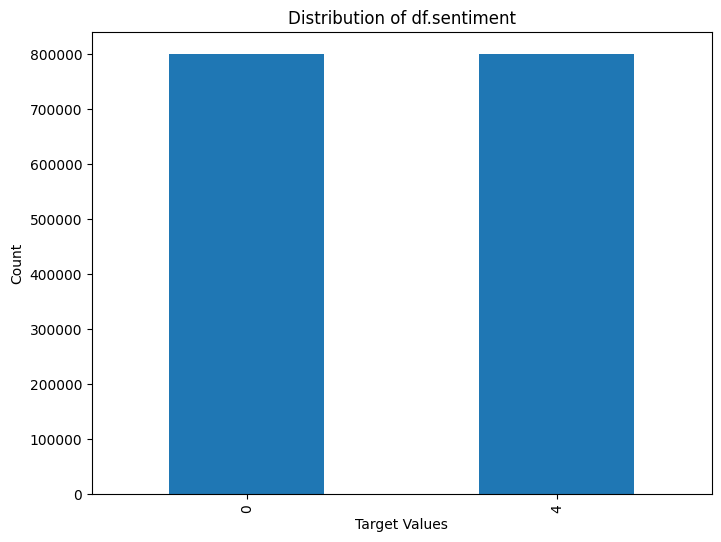

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'target' is the column you want to plot
plt.figure(figsize=(8, 6))
dataset['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribution of df.sentiment')
plt.xlabel('Target Values')
plt.ylabel('Count')
plt.show()

In [ ]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])
text[:5]

<ipython-input-5-07e42e6b1299>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###Pre-Process dataset

In [ ]:
lemmatizer = WordNetLemmatizer()
# grouping together the inflected forms ("better" -> "good")

def preprocess(textdata):
    processed_texts = []

    # Defining regex patterns.
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(url_pattern, ' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            # Replace @USERNAME to 'USER'.
        tweet = re.sub(user_pattern, ' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alpha_pattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

        preprocessed_words = []
        for word in tweet.split():
            # Check if the word is a stopword.
            if len(word) > 1 and word not in stopwords:
                # Lemmatizing the word.
                word = lemmatizer.lemmatize(word)
                preprocessed_words.append(word)

        processed_texts.append(' '.join(preprocessed_words))

    return processed_texts

In [ ]:
processedtext = preprocess(text)

In [ ]:
processedtext[:5]

['USER URL aww bummer shoulda got david carr third day EMOJIwink',
 'upset update facebook texting might cry result school today also blah',
 'USER dived many time ball managed save 50 rest go bound',
 'whole body feel itchy like fire',
 'USER no not behaving mad see over']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)

###TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [ ]:
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [ ]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.81     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



###Building Pipeline

In [ ]:
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)

pipe = Pipeline([('vectorizer', vectorizer), ('bnb', BNBmodel)])
pipe.fit(X_train, y_train)

model_evaluate(pipe)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



In [ ]:
with open('pipeline.pickle','wb') as f:
    pickle.dump(pipe, f)

with open('pipeline.pickle', 'rb') as f:
    loaded_pipe = pickle.load(f)

model_evaluate(loaded_pipe)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



###Predicting

In [ ]:
def predict(model, text):

    preprocessed_text = preprocess(text)
    predictions = model.predict(preprocessed_text)

    pred_to_label = {0: 'Negative', 1: 'Positive'}


    data = []
    for t, pred in zip(text, predictions):
        data.append((t, pred, pred_to_label[pred]))

    return data


if __name__=="__main__":
    # Text to classify should be in a list.
    text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good"]

    predictions = predict(loaded_pipe, text)
    print(predictions)

[('I hate twitter', 0, 'Negative'), ('May the Force be with you.', 1, 'Positive'), ("Mr. Stark, I don't feel so good", 0, 'Negative')]
